In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import pickle
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 
import os

In [2]:
file_path = "610_ps4_test\\610_ps4_test\\testingT2HAR\\har_test.csv"
model_path = "models\\t2"
random_seed = 42

In [3]:
data = pd.read_csv(file_path, header=None)

In [4]:
def drop_cols(df):
    cols_dropped = pd.read_csv(os.path.join(model_path, 'Task_2_Dropped_Cols.csv'), header=0).values
    cols_dropped = [x[0] for x in cols_dropped]
    return df.drop(columns=cols_dropped)

In [5]:
def scalar(df):
    # load tranformer
    scaler = pickle.load(open(os.path.join(model_path, 'scaler.pkl'), 'rb'))
    # Apply transform to both the train set and the test set. 
    return scaler.transform(df)

In [6]:
def label_encode(y):
    # load tranformer
    le = pickle.load(open(os.path.join(model_path, 'le.pkl'), 'rb'))
    # Apply transform to both the train set and the test set. 
    return pd.Series(le.transform(y))

In [7]:
def preprocess(df,y):
    df = drop_cols(df)
    
    df = scalar(df)
    
    y = label_encode(y)    
    
    df = pd.DataFrame(df)
    y = pd.Series(y)
    return df, y

In [8]:
print("Processing Dataset")
data_x_pp, data_y_pp  = preprocess(data.iloc[:,:-1],y=data.iloc[:,-1])

Processing Dataset


In [9]:
def get_class_weights(y):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    weights = {k: v for k, v in zip(np.unique(y), class_weights)}
    # Assigning weights to each instance in the training set
    sample_weights = y.map(weights)
    return sample_weights

In [10]:
dmatrix = xgb.DMatrix(data_x_pp, data_y_pp, missing=0.0, feature_weights=get_class_weights(data_y_pp))

In [11]:
label_encode(['Sitting'])

0    5
dtype: int32

Classification report
                   precision    recall  f1-score   support

          Cycling       0.96      0.90      0.92        48
         Football       0.75      0.96      0.84        68
          Jogging       0.50      0.50      0.50         2
         JumpRope       0.93      0.62      0.74        21
          Pushups       1.00      0.67      0.80         3
          Sitting       0.98      0.99      0.99       123
         Swimming       0.68      0.59      0.63        22
           Tennis       0.78      0.78      0.78       103
          Walking       0.82      0.90      0.86        10
WalkingDownstairs       0.29      0.13      0.18        15
  WalkingUpstairs       0.67      0.71      0.69        17

         accuracy                           0.84       432
        macro avg       0.76      0.70      0.72       432
     weighted avg       0.83      0.84      0.83       432


Accuracy
0.8379629629629629

Macro F1
0.7208793590317542



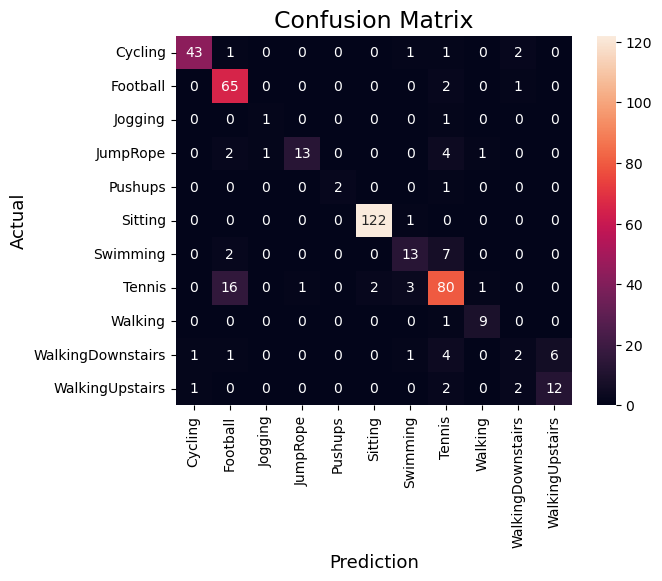

In [12]:
# load model
model = pickle.load(open(os.path.join(model_path, 'model.pkl'), 'rb'))
    
predsxgb = model.predict(dmatrix)
preds = np.argmax(predsxgb,axis=1)

# get labels
le = pickle.load(open(os.path.join(model_path, 'le.pkl'), 'rb'))
labels = le.inverse_transform(range(0,11))

print("Classification report")
print(classification_report(data_y_pp, preds, labels=range(0,11), target_names=labels))
print()
print("Accuracy")
print(accuracy_score(data_y_pp, preds))
print()
print("Macro F1")
print(f1_score(data_y_pp, preds, average='macro'))
print()
cm = confusion_matrix(data_y_pp,preds)
sns.heatmap(cm, 
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# replace ground truth with preds
data.iloc[:,-1] = le.inverse_transform(preds)

# export as csv
data.to_csv("Task_2_Prediction.csv", index=False)

## For baseline

Classification report
                   precision    recall  f1-score   support

          Cycling       0.00      0.00      0.00        48
         Football       0.00      0.00      0.00        68
          Jogging       0.00      0.00      0.00         2
         JumpRope       0.00      0.00      0.00        21
          Pushups       0.00      0.00      0.00         3
          Sitting       0.28      1.00      0.44       123
         Swimming       0.00      0.00      0.00        22
           Tennis       0.00      0.00      0.00       103
          Walking       0.00      0.00      0.00        10
WalkingDownstairs       0.00      0.00      0.00        15
  WalkingUpstairs       0.00      0.00      0.00        17

         accuracy                           0.28       432
        macro avg       0.03      0.09      0.04       432
     weighted avg       0.08      0.28      0.13       432


Accuracy
0.2847222222222222

Macro F1
0.04029484029484029



C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


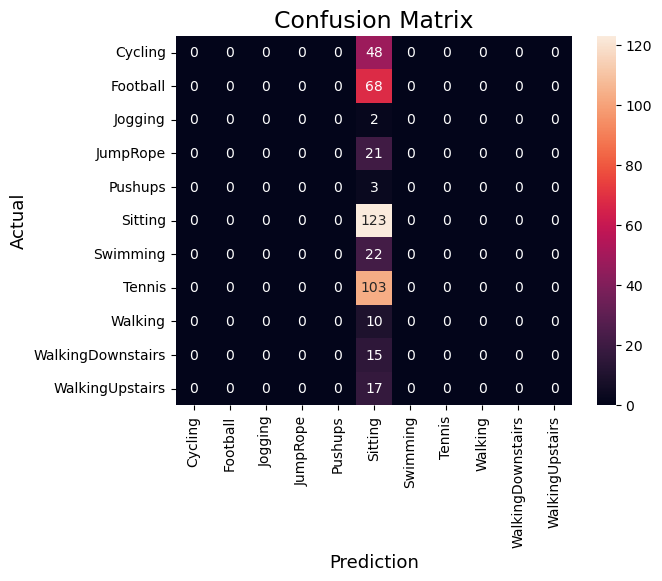

In [14]:
preds = [5]*len(data_y_pp)

# get labels
le = pickle.load(open(os.path.join(model_path, 'le.pkl'), 'rb'))
labels = le.inverse_transform(range(0,11))

print("Classification report")
print(classification_report(data_y_pp, preds, labels=range(0,11), target_names=labels))
print()
print("Accuracy")
print(accuracy_score(data_y_pp, preds))
print()
print("Macro F1")
print(f1_score(data_y_pp, preds, average='macro'))
print()
cm = confusion_matrix(data_y_pp,preds)
sns.heatmap(cm, 
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# replace ground truth with preds
data.iloc[:,-1] = le.inverse_transform(preds)

# export as csv
data.to_csv("Task_2_Prediction_baseline.csv", index=False)